# Application of supervised learning

The "Medical Cost Personal" dataset, available on Kaggle, provides a rich source of information on individual patients' health insurance data, which can be instrumental in understanding the factors influencing the cost of their medical treatment. The dataset encompasses six independent features, namely age, sex, body mass index (BMI), number of children, smoking status, and region of residence. 

The data is in the "data/supervised_learning_data" folder and is available on kaggle: [https://www.kaggle.com/datasets/mirichoi0218/insurance](https://www.kaggle.com/datasets/mirichoi0218/insurance)

### Why Linear regression model?

Linear regression is a supervised learning algorithm used when target / dependent variable continues real number. It establishes relationship between dependent variable  y and one or more independent variable  x using best fit line.

Now we need to load the data, conduct different analysis and if needed preprocess the data so that we can apply the linear regression model.

### Load the Data

In [342]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import plotly.express as px

In [343]:
dataset_folder = Path('../../data/supervised_learning_data/')
dataset_folder.resolve()

WindowsPath('C:/Users/josep/Documents/epita_scia/FTML/projet/FTML/data/supervised_learning_data')

In [344]:
data = pd.read_csv(dataset_folder.joinpath('insurance.csv'))
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [345]:
data.shape

(1338, 7)

### EDA approach (Exploratory Data Analysis)

EDA is an approach to analyzing and summarizing datasets in order to gain insights and understand the underlying patterns and relationships within the data. 

#### Do we need to clean the data?

In [346]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [347]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


We can see that there is no missing values using the data.info and that the values for each column seems consistent. 
We need to note however that the columns named "children" and "charges" are skewed. 

#### Check if there are correlations between variables

note : the closer from 1, the higher the correlation is

C:\Users\josep\AppData\Local\Temp\ipykernel_37868\2237571826.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

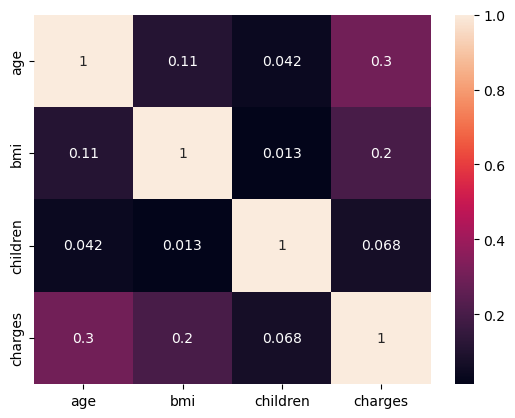

In [348]:
my_corr_data = data.corr()
sns.heatmap(my_corr_data, annot= True)

#### Using all of this we can see that :
- The dataset, shaped as (1338,7), comprises 1338 individual patient entries (rows) and 7 attributes (columns).
- 'Charges' is the target variable we aim to predict, while the other six (age, sex, BMI, children, smoker, and region) are the independent variables used for prediction.
- Given the presence of multiple independent variables, a Multiple Linear Regression model is needed to best predict the 'charges' based on these variables.

Attention: important to note that high correlation doesn't mean causation

#### See for exemple the correlation between sex and charge

In [349]:
df = data.copy()
fig = px.histogram(df, 
                   x='charges', 
                   color='sex',
                   color_discrete_sequence=['blue', 'orange']
)
fig.show()

In [350]:
fig = px.histogram(df, 
                   x='bmi', 
                   color='sex',
                   color_discrete_sequence=['blue', 'orange']
)
fig.show()

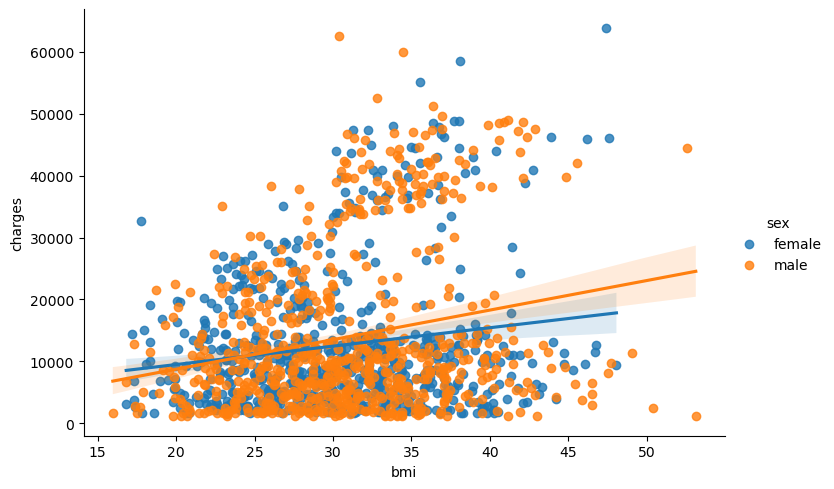

In [351]:
sns.lmplot(x='bmi',y='charges',hue='sex',data=data,aspect=1.5,height=5)

We see that for most costumers the price is between 0 and 20k, and that there are more male costumer than female costumer.
We can also see that there are more male costumers that have a greater bmi.

The general trend seems to be that being overweighted will be charged more and because more males are overweighted, there is indeed a correlation between having more medical fees and being a male, though maybe small.

#### We are quickly looking at the correlation between charge and three interesting variables : age, smokers and regions

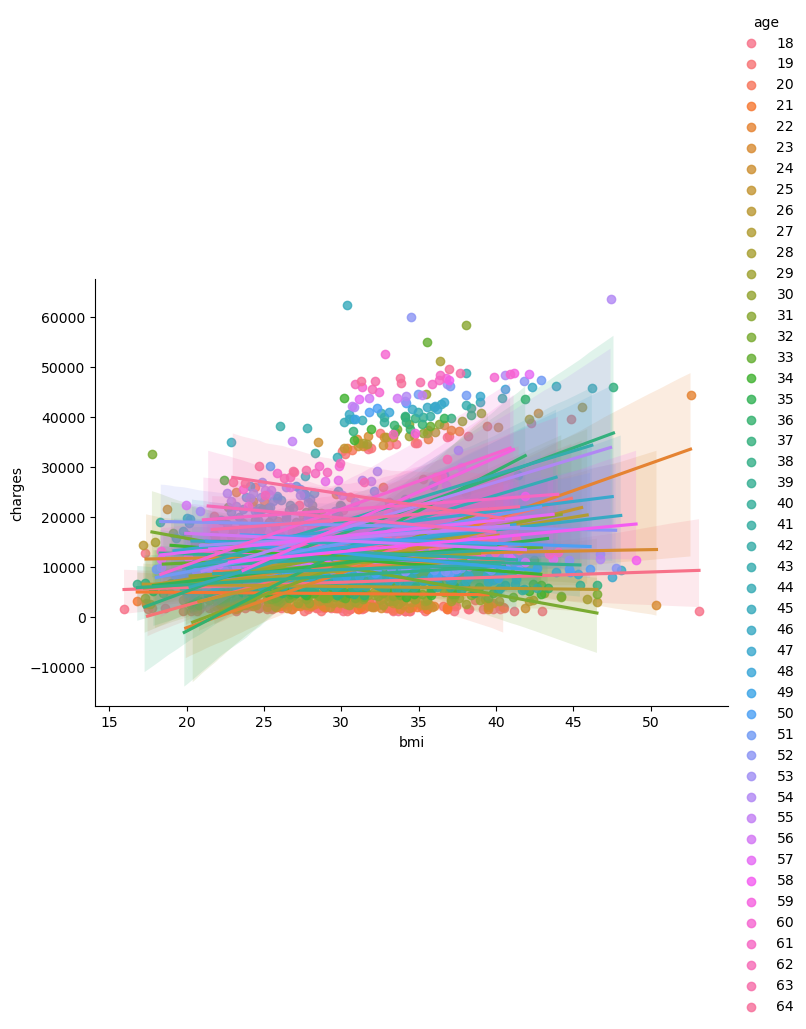

In [352]:
sns.lmplot(x='bmi',y='charges',hue='age',data=data,aspect=1.5,height=5)

It seems that the older they get, the higher their medical fees is.

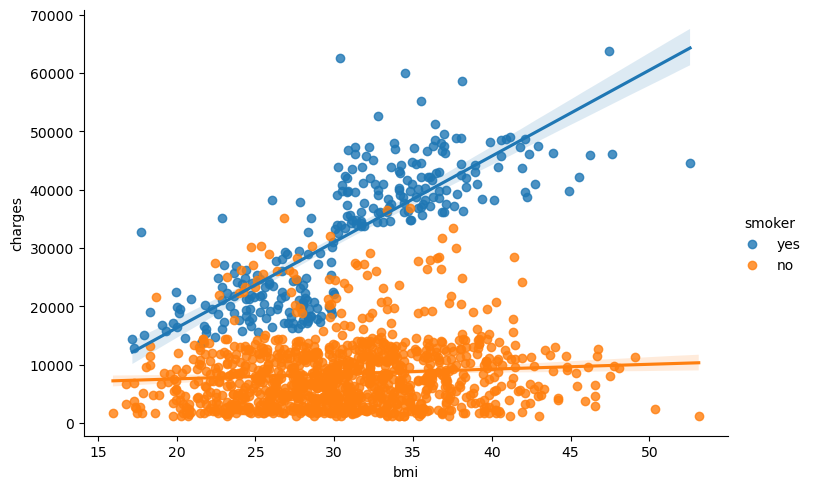

In [353]:
sns.lmplot(x='bmi',y='charges',hue='smoker',data=data,aspect=1.5,height=5)

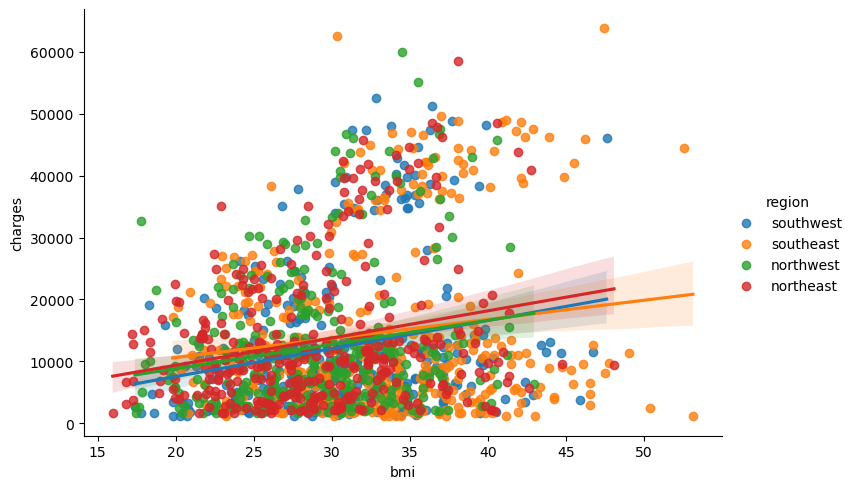

In [354]:
sns.lmplot(x='bmi',y='charges',hue='region',data=data,aspect=1.5,height=5)

It seems that those variables that we talk about above have a correlation (that is strong for age or smoker for exemple).

Then let's do a linear regression on multiple features.

### Function that split and train the model

In [355]:
def compute(data, param = False, polynomial = False):
    X = data.drop('charges',axis=1) # Independet variable
    y = data['charges'] # dependent variable
    X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.3,random_state=1)

    # model
    model = LinearRegression(fit_intercept= param)
    
    #The updated version using polynomial features
    if polynomial:
        poly_mod = PolynomialFeatures(degree = 2, interaction_only = True)
        X_train = poly_mod.fit_transform(X_train)
        X_test = poly_mod.fit_transform(X_test)
    
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    
    print('The score of my model is: ', model.score(X_test, Y_test))
    print('The R squared score of my model is: ', r2_score(predictions, Y_test))
    print('The coefficients are: ', model.coef_)
    print('The Mean Square Error is: ', np.sqrt(mean_squared_error(predictions, Y_test)))

    #Plot the corresponding graph for linearity
    plt.plot(Y_test,predictions,'o')
    m,b = np.polyfit(Y_test,predictions,1)
    plt.plot(Y_test,m*Y_test+b)
    plt.show()
    
    return model

In [356]:
def cross_val(model, data):
    X = data.drop('charges',axis=1) # Independet variable
    y = data['charges'] # dependent variable
    kfold = 50
    return cross_val_score(model, X, y, cv=kfold)

### Data processing

However before doing so, as ML algorithms doesn't work with categorical data directly we need to turn it into numerical values. For these we have three possibilities: "Dummy variable", "Label Encoding" and "One hot encoding"

To do all of them we will use the get_dummies 

In [357]:
# get dummies for categorical columns
data = pd.get_dummies(data, columns = ['sex', 'smoker', 'region'],drop_first =True,
              dtype='int8')
data.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [358]:
print(data.columns.values)

['age' 'bmi' 'children' 'charges' 'sex_male' 'smoker_yes'
 'region_northwest' 'region_southeast' 'region_southwest']


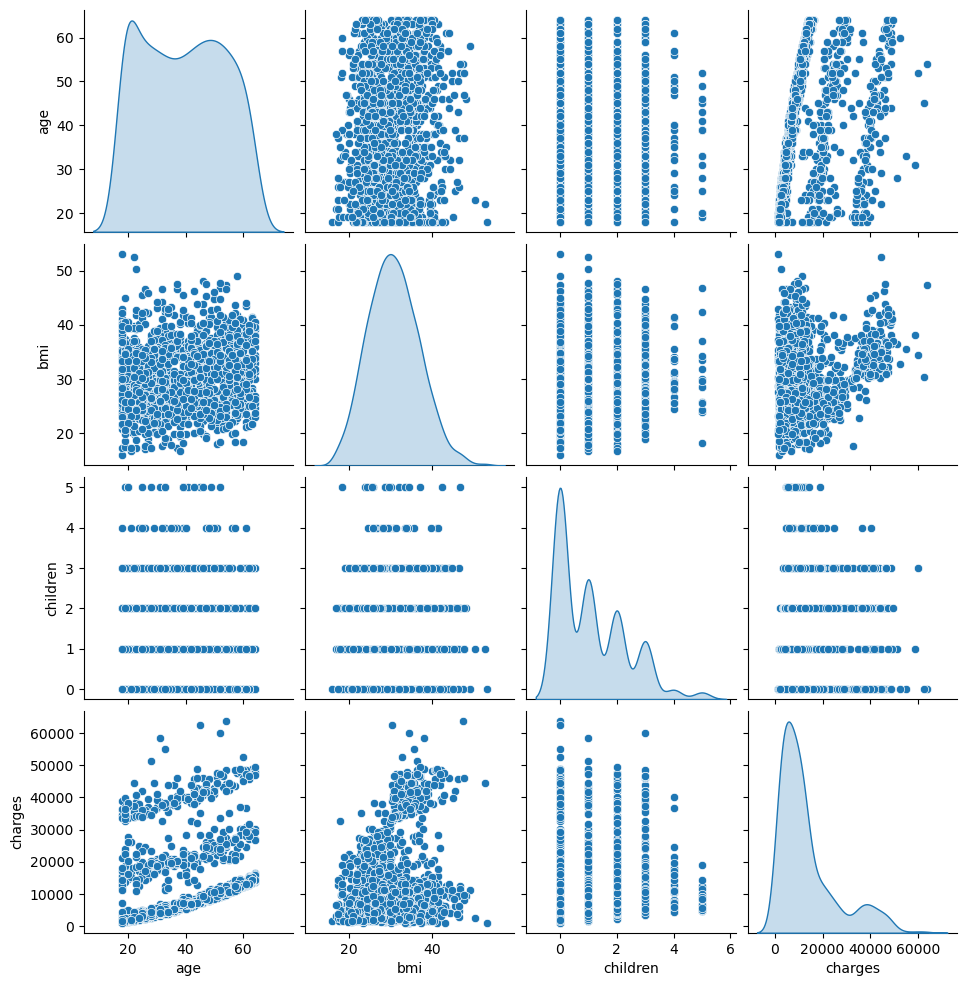

In [359]:
sns.pairplot(data.iloc[:, 0:4], diag_kind = 'kde')

### Estimator for data with preprocessing

The score of my model is:  0.7037657478724582
The R squared score of my model is:  0.5618498609703693
The coefficients are:  [  203.48018706    70.8740709    141.52623738  -793.21590669
 23667.0413604  -1495.8995984  -1188.83849851 -1718.17278179]
The Mean Square Error is:  6479.300318399866


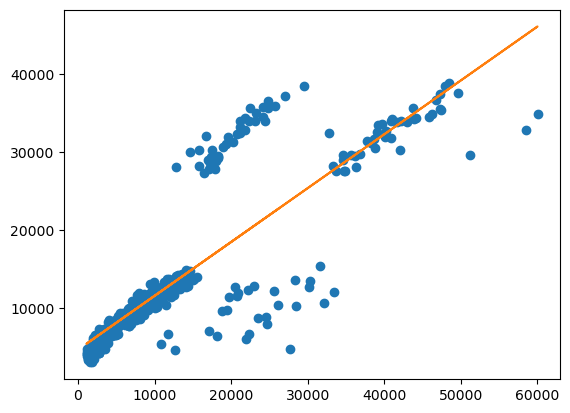

In [360]:
model = compute(data)

It seems that the model that returns the estimator of 0.70 % fits the data, however we can see on the graph that the relationship between the dependent and independent variable is not exactly linear.

It is not the best situation and we should handle the model a bit differently so that we could get better results.

### However the model can be better

In order to improve the model's accuracy there are three techniques:
- Multicollinearity is addressed by identifying and removing highly correlated independent variables, improving model stability and interpretability.
- Polynomial Features are used to capture more complex relationships.
- Gradient Descent is an optimization algorithm that iteratively adjusts model parameters to minimize the difference between the predicted and actual values, boosting model accuracy.

Here we will focus on polynomial features.

#### Polynomial Features

The score of my model is:  0.8414518898662803
The R squared score of my model is:  0.8051144942701008
The coefficients are:  [-1.03545112e+03  1.56291864e+02  5.62765289e+01  7.31784795e+02
 -1.44497450e+03 -1.91529525e+04 -1.36556167e+02  3.06890138e+03
 -4.31333969e+02  1.74719890e+00  4.42200778e+00  2.34219480e+01
 -5.05453916e+00  5.80578809e+00  6.33698723e+01  5.71838833e+01
 -1.26400647e+01 -5.86868540e-01  1.45152297e+03 -3.08106601e+01
 -2.11966863e+02 -1.00035233e+02 -1.15573347e+02 -7.89991643e+02
  4.94053434e+02 -6.32752925e+01 -8.30666269e+01 -6.13669899e+02
 -2.03167571e+02  5.89764129e+02  1.34579836e+01 -3.82506410e+02
 -5.33884861e+02  6.95695899e+02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
The Mean Square Error is:  4740.138253855826


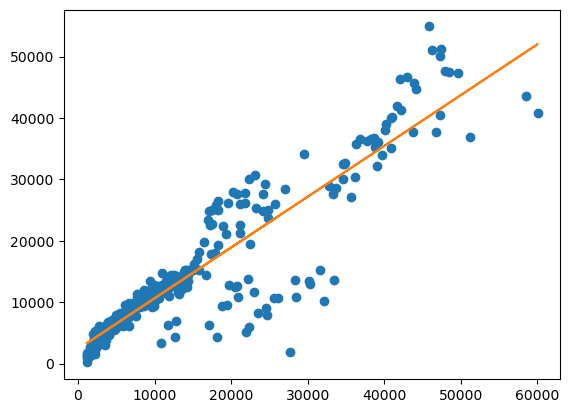

In [361]:
model = compute(data, polynomial = True)

Now the estimation is higher than before being at 0.84% instead of 70%.
The graph shows also that the model seems to fit the data better which is confirmed with the mean squared error which is smaller than before.

So we can see that polynomial features feat the data better as it helps with relationship between variables aren't exactly linear, which helps with enhancing the accuracy.

### Conclusion

Conducting a linear regression on this dataset was a better idea than doing a classification as it seems to feat the data better. 

However after:
- exploring the data and finding correlations between inputs and targets
- picking the linear regression model
- scaling numeric variables and one-hot encode categorical data
- setting aside a test set (using a fraction of the training set)
- training the model
- making predictions on the test set 

We have seen that it was necessary to optimize the problem at hand as we have done in the exemple with the  polynomial features.

However as the model stills needs improvement, it might have been better to try and compare with other model as XGBoost regression.